In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
import clip
from PIL import Image
import time
from matplotlib.patches import Rectangle
from skimage.io import imread
from skimage.transform import resize
from PIL import Image

In [3]:
def get_data(file_name):
    with open(file_name) as f:
        data = json.load(f)
    img_names = [[dt['id'], dt['file_name']] for dt in data['images']]
    imgToAnns = {ann['image_id']: [] for ann in data['annotations']}    
    for ann in data['annotations']:
        ann['caption'] = pre_process_text(ann['caption'])        
        imgToAnns[ann['image_id']] += [ann]                
    return img_names, imgToAnns


def pre_process_text(text):
    forbiden_char = "?.;:!,$#%/'()[]0123456789=´+-&@`" + '"'
    text = text.lower()
    text = "".join(u for u in text if u not in forbiden_char)
    return text

def draw_boxes(image, v_boxes, v_labels, v_scores):
    plt.figure(figsize=(8, 8))     
    plt.imshow(image)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for i in range(len(v_boxes)):
        lbl = v_labels[i]
        #if lbl!=classlbl:
        #    continue
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='red')
    # show the plot
    plt.show()
    
def clip_score(image_features, cap_features):
    score = image_features * cap_features
    score = torch.sum(score, -1)
    score = torch.maximum(score, torch.zeros_like(score))
    return score * 2.5

def clip_ref_score(image_features, cap_features, ref_features):
    c_score = clip_score(image_features, cap_features)
    r_score = []
    for c, r in zip(cap_features, ref_features):
        s = r @ c
        m = torch.max(s)
        r_score.append(torch.maximum(m, torch.zeros_like(m)))
    r_score = torch.stack(r_score)
    return 1/((1/c_score + 1/r_score)/2)

In [4]:
with open("data-mask-rcnn-detections.json") as f:
    data_mask = json.load(f)

In [5]:
data_file = '/data1/shared/COCO2017/annotations/captions_val2017.json'
path = '/data1/shared/COCO2017/val2017/'
img_names, img2anns = get_data(data_file)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load image features

In [7]:
#np.save("COCO2017_val_clip_features.npy", images_features)
images_features = np.load("COCO2017_val_clip_features.npy")
images_features = torch.tensor(images_features, dtype=torch.float32)

In [8]:
def cap_features(captions):
    text = clip.tokenize(captions).to(device)
    with torch.no_grad():
        features = model.encode_text(text)    
    return features / features.norm(dim=-1, keepdim=True)   


In [9]:
idx = 19
img_id, img_fn = img_names[idx]
cap = img2anns[img_id][2]['caption']

In [10]:
def rate_words(caption, img_feat):
    words = cap.split()
    l = len(words)
    caps = [cap]
    for i in range(l):
        caps.append(" ".join(words[0:i] + words[i+1:l]))
    caps_feat = cap_features(caps)
    score = clip_score(img_feat, caps_feat)
    ranks = torch.maximum(1-(score / score[0]), torch.zeros_like(score))[1:]
    return ranks, caps_feat[0]

In [11]:
words = cap.split()

## Enmascarar palabras del caption

### Score

In [12]:
ranks, caps_feat = rate_words(cap, images_features[idx])
ranks

tensor([0.0064, 0.0414, 0.0450, 0.0162, 0.0293, 0.0475, 0.0574, 0.0000, 0.0308,
        0.1018, 0.0000])

# Results

In [13]:
cap

'small parking lot of cars in front of a stone building'

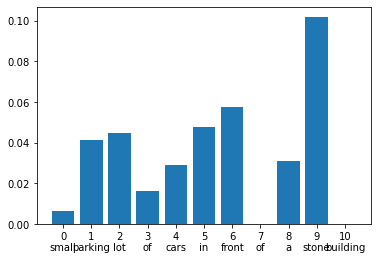

In [14]:
plt.bar([f"{i}\n{w}" for i,w in enumerate(words)], ranks)
plt.show()

In [15]:
P = torch.sum(ranks>0) / len(words)
P

tensor(0.8182)

In [16]:
img = imread(path + data_mask[str(img_id)]["id_im"][1])

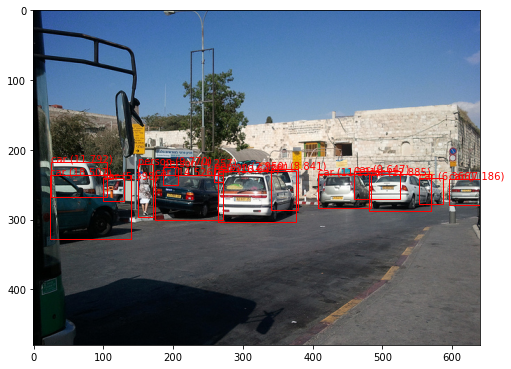

In [17]:
draw_boxes(img, data_mask[str(img_id)]['posiciones'], data_mask[str(img_id)]['clases_im'], data_mask[str(img_id)]['porcentaje'])

## Enmascarar objetos.

In [18]:
def mask_objects(img_id):
    img = imread(path + data_mask[str(img_id)]["id_im"][1])
    imgs_masked = [img]
    imgs_clases = []
    for cl in set(data_mask[str(img_id)]['clases_im']):
        imgs_clases.append(cl)
        im = np.array(img)
        mask_pos = np.where(np.array(data_mask[str(img_id)]['clases_im']) == cl)[0]
        for pos in mask_pos:
            y1, x1, y2, x2 = data_mask[str(img_id)]['posiciones'][pos]
            im[y1:y2,x1:x2] = np.array([0,0,0])        
        imgs_masked.append(im)
    return imgs_masked, imgs_clases

In [19]:
imgs_masked, imgs_clases = mask_objects(img_id)

person


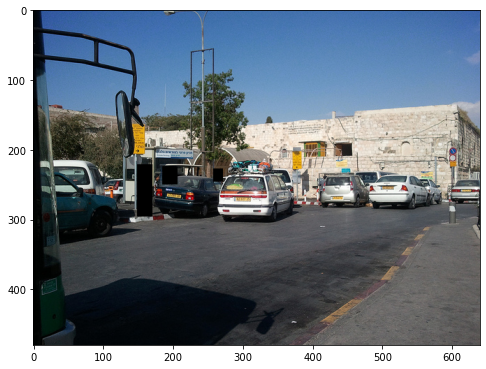

In [21]:
cl_idx = 1
print(imgs_clases[cl_idx])
plt.figure(figsize=(8, 8))
plt.imshow(imgs_masked[cl_idx+1])
plt.show()

Sacar features de imágenes

In [22]:
def rank_objects(img_id, caps_feat):
    imgs_masked, imgs_clases = mask_objects(img_id)
    imgs_masked_feat = np.zeros((len(imgs_masked), 512))
    for i in range(len(imgs_masked)):
        im = Image.fromarray(imgs_masked[i])
        img = preprocess(im).unsqueeze(0).to(device)
        with torch.no_grad():
            imgs_masked_feat[i] = model.encode_image(img)
    imgs_masked_feat = torch.tensor(imgs_masked_feat, dtype=torch.float32)
    imgs_masked_feat /= imgs_masked_feat.norm(dim=-1, keepdim=True)  
    ranks = clip_score(imgs_masked_feat, caps_feat)
    return (ranks / ranks[0])[1:], imgs_clases

In [27]:
ranks, img_clases = rank_objects(img_id, caps_feat)
1-ranks, img_clases

(tensor([0.1679, 0.0034]), ['car', 'person'])

In [28]:
R = torch.sum((1 - ranks) > .1) / len(img_clases)

In [29]:
F1 = 2*P*R/(P+R)
print(P, R, F1)

tensor(0.8182) tensor(0.5000) tensor(0.6207)


the signs give the street names and show where to park


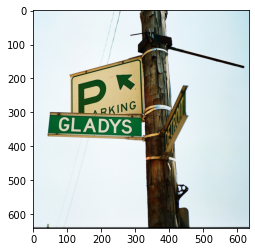

In [39]:
print(cap)
plt.imshow(img)
plt.show()